# Downloading data and importing libraries

In [5]:
! pip install -q kaggle

In [6]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/ 
! chmod 600 ~/.kaggle/kaggle.json

In [7]:
! kaggle competitions download -c nlp-getting-started

  0% 0.00/593k [00:00<?, ?B/s]
100% 593k/593k [00:00<00:00, 128MB/s]


In [8]:
! unzip nlp-getting-started.zip

Archive:  nlp-getting-started.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [9]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import string
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# importing dataset

In [10]:
train = pd.read_csv("/content/train.csv")
test = pd.read_csv("/content/test.csv")
sample_submission = pd.read_csv("/content/sample_submission.csv")

# Inspecting data

In [11]:
train.head(5)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [12]:
test.head(5)

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [13]:
sample_submission.head()

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0


In [14]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [15]:
train.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

Training set has:
* 7613 examples
* 5 features
* 61 null values in keywords
* 2553 null values in location

In [16]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


In [17]:
test.isnull().sum()

id             0
keyword       26
location    1105
text           0
dtype: int64

Test set has:
* 3263 examples
* 4 features
* 26 null values in keywords
* 1105 null values in location

In [18]:
train['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

# Data Preprocessing

In [19]:
# regular expressions from https://www.kaggle.com/code/uditsharma72/disaster-tweets-lstm-acc-97-66
# strips simple unnecessary text from input strings

def strip_text(input_text):
  # set to lowercase
  lower = tf.strings.lower(input_text)

  # remove hyperlinks
  stripped_hyperlinks = tf.strings.regex_replace(lower, 'https?://\S+|www\.\S+', '')

  # remove hashtags
  stripped_hashtags = tf.strings.regex_replace(stripped_hyperlinks, '#', '')

  # remove newlines
  stripped_newlines = tf.strings.regex_replace(stripped_hashtags, '\n', '')

  # remove punctuations
  stripped_punc = tf.strings.regex_replace(stripped_newlines, '[%s]' % re.escape(string.punctuation), '')

  # remove brackets
  stripped_brackets = tf.strings.regex_replace(stripped_punc, '\[.*?\]', '')

  # remove words w/ numbers
  stripped_nums = tf.strings.regex_replace(stripped_brackets, '\w*\d\w*', '')

  return tf.strings.regex_replace(stripped_nums, '[%s]' % re.escape(string.punctuation), '')

# Removing stopwords from input strings
def strip_stopwords(input_text):
  return [x for x in input_text if x not in stopwords.words('english')]



In [20]:
# stripping train and test text and stopwords
train['text'] = strip_text(train['text'])
train['text'] = strip_stopwords(train['text'])
train_text = train['text'].to_numpy()
train_text = [x.decode('utf-8') for x in train_text]

test['text'] = strip_text(test['text'])
test['text'] = strip_stopwords(test['text'])
test_text = test['text'].to_numpy()
test_text = [x.decode('utf-8') for x in test_text]

In [21]:
train.head(10)

,id,keyword,location,text,target
0,1,NaN,NaN,b'our deeds are the reason of this earthquake ...,1
1,4,NaN,NaN,b'forest fire near la ronge sask canada',1
2,5,NaN,NaN,b'all residents asked to shelter in place are ...,1
3,6,NaN,NaN,b' people receive wildfires evacuation orders ...,1
4,7,NaN,NaN,b'just got sent this photo from ruby alaska as...,1
5,8,NaN,NaN,b'rockyfire update california hwy closed in ...,1
6,10,NaN,NaN,b'flood disaster heavy rain causes flash flood...,1
7,13,NaN,NaN,b'im on top of the hill and i can see a fire i...,1
8,14,NaN,NaN,b'theres an emergency evacuation happening now...,1
9,15,NaN,NaN,b'im afraid that the tornado is coming to our ...,1


In [22]:
# tokenizing input string
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

max_text_len = 240 # max tweet character length

# max dictionary size of 10000 words
tokenizer = Tokenizer(num_words=10000, oov_token='OOV')
tokenizer.fit_on_texts(train_text)
train_seq = tokenizer.texts_to_sequences(train_text)
train_seq = pad_sequences(train_seq, maxlen=max_text_len)

# Shuffling and splitting data

In [59]:
# creating clean test set
X = train_seq
Y = train['target'].to_numpy()
x_test  = X[(-int(len(X) * 0.2)):]
y_test  = Y[(-int(len(X) * 0.2)):]
X_train = X[0:(-int(len(X) * 0.2))]
Y_train = Y[0:(-int(len(X) * 0.2))]

# print(x_test.shape, y_test.shape)
# print(X_train.shape, Y_train.shape)

# shuffling data
shuffler = np.random.permutation(len(X_train))
X_train = X_train[shuffler]
Y_train = Y_train[shuffler]
# print(len(X), X.shape, len(Y))

# splitting into train and validation sets
x_train = X_train[:int((len(X_train) * 0.8))]
x_val   = X_train[(-int(len(X_train) * 0.2)):]

y_train = Y_train[:int((len(Y_train) * 0.8))]
y_val   = Y_train[(-int(len(Y_train) * 0.2)):]

In [41]:
percent_disasters = np.count_nonzero(y_test) / (np.count_nonzero(y_test) + y_test[np.where(y_test == 0)].size)
print(f'percent disaster tweets in test set: {percent_disasters}')

percent_disasters = np.count_nonzero(Y_train) / (np.count_nonzero(Y_train) + Y_train[np.where(Y_train == 0)].size)
print(f'percent disaster tweets in training/val set: {percent_disasters}')

percent disaster tweets in test set: 0.46583442838370565
percent disaster tweets in training/val set: 0.4206205877524216


# Creating ML Model

In [42]:
# Early stopping callbacks for loss and auc
early_stopping_auc = tf.keras.callbacks.EarlyStopping(monitor='val_auc', patience=2, mode='max')
early_stopping_loss = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)

In [43]:
# Learning rate callback
from keras.callbacks import LearningRateScheduler

def scheduler(epoch, lr):
  # first two epochs have constant lr
  if epoch < 2:
    return 0.00005
  else:
    # decay of 1% per epoch
    return lr * 0.99

lr_scheduler = LearningRateScheduler(scheduler)

In [44]:
# function to create model

def create_model():
  input_dimensions = 10000
  input_length = max_text_len

  model = tf.keras.Sequential([
                             tf.keras.layers.Embedding(input_dim=input_dimensions, output_dim=64, input_length=input_length),
                             tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, activation='tanh')),
                             tf.keras.layers.Dense(64, activation='relu'),
                             tf.keras.layers.Dense(64, activation='relu'),
                             tf.keras.layers.Dropout(0.5),
                             tf.keras.layers.Dense(1, activation='sigmoid')
  ])
  model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=['AUC'])
  return model

In [29]:
# selecting batch_size
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

model = KerasClassifier(build_fn=create_model)
params = {'batch_size':[25, 50, 75, 100, 125, 150]}


gs = GridSearchCV(estimator=model, param_grid=params, cv=5, scoring='roc_auc')

gs = gs.fit(X_train, Y_train, epochs=100, validation_split=0.2, callbacks=[lr_scheduler, early_stopping_auc, early_stopping_loss])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  """


Epoch 1/100
78/78 [==============================] - 8s 48ms/step - loss: 0.6900 - auc: 0.5202 - val_loss: 0.6856 - val_auc: 0.5186 - lr: 5.0000e-05
Epoch 2/100
78/78 [==============================] - 3s 35ms/step - loss: 0.6822 - auc: 0.5194 - val_loss: 0.6789 - val_auc: 0.5480 - lr: 5.0000e-05
Epoch 3/100
78/78 [==============================] - 3s 34ms/step - loss: 0.6789 - auc: 0.5344 - val_loss: 0.6768 - val_auc: 0.6032 - lr: 4.9500e-05
Epoch 4/100
78/78 [==============================] - 3s 37ms/step - loss: 0.6741 - auc: 0.5842 - val_loss: 0.6728 - val_auc: 0.6729 - lr: 4.9005e-05
Epoch 5/100
78/78 [==============================] - 3s 34ms/step - loss: 0.6651 - auc: 0.6533 - val_loss: 0.6573 - val_auc: 0.7170 - lr: 4.8515e-05
Epoch 6/100
78/78 [==============================] - 3s 35ms/step - loss: 0.6310 - auc: 0.7569 - val_loss: 0.6156 - val_auc: 0.7635 - lr: 4.8030e-05
Epoch 7/100
78/78 [==============================] - 3s 34ms/step - loss: 0.5493 - auc: 0.8365 - val_loss:

In [31]:
gs.best_params_

{'batch_size': 50}

In [45]:
# shuffling data again before training
shuffler = np.random.permutation(len(X_train))
X_train = X_train[shuffler]
Y_train = Y_train[shuffler]
# print(len(X), X.shape, len(Y))

# splitting into train and validation sets
x_train = X_train[:int((len(X_train) * 0.8))]
x_val   = X_train[(-int(len(X_train) * 0.2)):]

y_train = Y_train[:int((len(Y_train) * 0.8))]
y_val   = Y_train[(-int(len(Y_train) * 0.2)):]

print(y_train.shape, y_val.shape)

(4872,) (1218,)


In [46]:
# training model
model = create_model()
history = model.fit(
                    np.array(x_train),
                    np.array(y_train),
                    epochs=100,
                    batch_size=50,
                    callbacks=[early_stopping_auc, early_stopping_loss, lr_scheduler],
                    validation_data=(x_val, y_val)
                    )
history = history.history

Epoch 1/100
98/98 [==============================] - 12s 39ms/step - loss: 0.6902 - auc: 0.4950 - val_loss: 0.6855 - val_auc: 0.5415 - lr: 5.0000e-05
Epoch 2/100
98/98 [==============================] - 3s 30ms/step - loss: 0.6826 - auc: 0.5098 - val_loss: 0.6780 - val_auc: 0.6007 - lr: 5.0000e-05
Epoch 3/100
98/98 [==============================] - 3s 32ms/step - loss: 0.6795 - auc: 0.5308 - val_loss: 0.6754 - val_auc: 0.6757 - lr: 4.9500e-05
Epoch 4/100
98/98 [==============================] - 3s 32ms/step - loss: 0.6694 - auc: 0.6312 - val_loss: 0.6592 - val_auc: 0.7005 - lr: 4.9005e-05
Epoch 5/100
98/98 [==============================] - 3s 30ms/step - loss: 0.6295 - auc: 0.7492 - val_loss: 0.6051 - val_auc: 0.7626 - lr: 4.8515e-05
Epoch 6/100
98/98 [==============================] - 3s 30ms/step - loss: 0.5738 - auc: 0.8077 - val_loss: 0.5825 - val_auc: 0.8069 - lr: 4.8030e-05
Epoch 7/100
98/98 [==============================] - 3s 31ms/step - loss: 0.5328 - auc: 0.8556 - val_loss

# Analysing metrics

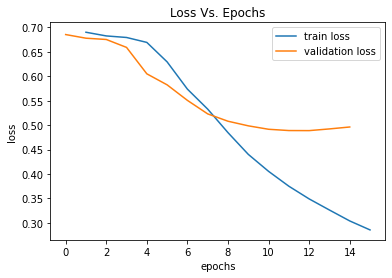

In [61]:
auc = history['auc']
val_auc = history['val_auc']
loss = history['loss']
val_loss = history['val_loss']
x = range(1, len(auc) + 1)

plt.plot(x, loss, label='train loss')
plt.plot(val_loss, label='validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('Loss Vs. Epochs')
plt.legend()
plt.show()

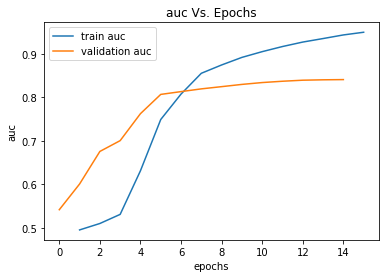

In [62]:
plt.plot(x, auc, label='train auc')
plt.plot(val_auc, label='validation auc')
plt.xlabel('epochs')
plt.ylabel('auc')
plt.title('auc Vs. Epochs')
plt.legend()
plt.show()

# Testing model predictions

In [426]:
test.head(5)

,id,keyword,location,text
0,0,NaN,NaN,b'just happened a terrible car crash'
1,2,NaN,NaN,b'heard about earthquake is different cities s...
2,3,NaN,NaN,b'there is a forest fire at spot pond geese ar...
3,9,NaN,NaN,b'apocalypse lighting spokane wildfires'
4,11,NaN,NaN,b'typhoon soudelor kills in china and taiwan'


In [427]:
# Making prediction on random example from test set
import random
random_number = random.randint(0, 3262)
test_data = test_text[random_number]
print(f'TEST TWEET [{random_number}]:\n{test_data}')

x_test = tokenizer.texts_to_sequences([test_data])
x_test = pad_sequences(x_test, maxlen=max_text_len)

test_pred = model.predict(np.array(x_test))

print(f'test soft prediction: {test_pred}')
test_pred = 1 if test_pred >= 0.5 else 0
print(f'test hard prediction: {test_pred}')

TEST TWEET [1041]:
bbc news  india rail crash trains derail in madhya pradesh flash flood 
test soft prediction: [[0.9582417]]
test hard prediction: 1


# Evaluating on clean test set

In [65]:
print(model.metrics_names)
test_loss, test_auc = model.evaluate(x_test, y_test)
print(f'test evaluation AUC: {test_auc}')

['loss', 'auc']
48/48 [==============================] - 1s 13ms/step - loss: 0.4714 - auc: 0.8519
test evaluation AUC: 0.8518728017807007


# Generating predictions and submission (Kaggle competition only)


In [447]:
x_test = tokenizer.texts_to_sequences(test_text)
x_test = pad_sequences(x_test, maxlen=max_text_len)

y_pred = model.predict(np.array(x_test))
y_pred = y_pred.flatten()
y_pred = y_pred.tolist()
y_pred = [1 if x >= 0.5 else 0 for x in y_pred]

In [448]:
submission = pd.DataFrame(
    {
        "id": test["id"].to_list(),
        "target": y_pred,
    }
)
submission = submission.set_index('id')

In [449]:
submission

,target
id,
0,0
2,1
3,1
9,0
11,1
...,...
10861,1
10865,0
10868,1


In [450]:
from google.colab import files
submission.to_csv('submission.csv', encoding = 'utf-8-sig')
files.download('submission.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>